<a href="https://colab.research.google.com/github/nalika/NLP/blob/master/CNN_model_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for Regression



In [0]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt


# Data loading

Downloading actual end-of-day ticker price and volume data from Yahoo Finance. Ref - [link text]https://www.red-gate.com/simple-talk/sql/bi/historical-stock-prices-volumes-python-csv-file/)

In [0]:
#import external pandas_datareader library with alias of web
import pandas_datareader as web
 
#import datetime internal datetime module
#datetime is a Python module
import datetime
 
#datetime.datetime is a data type within the datetime module
start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2017, 12, 31)
 
#DataReader method name is case sensitive
df = web.DataReader("nvda", 'yahoo', start, end)
 
#invoke to_csv for df dataframe object from 
#DataReader method in the pandas_datareader library
 
#..\first_yahoo_prices_to_csv_demo.csv must not
#be open in another app, such as Excel
 
df.to_csv('first_yahoo_prices_volumes_to_csv_demo.csv')

In [35]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-09-01,171.899994,169.600006,169.949997,170.460007,11135800.0,169.499313
2017-09-05,168.580002,163.559998,168.380005,165.910004,17384100.0,164.974976
2017-09-06,167.800003,164.399994,167.240005,165.809998,9941800.0,164.875534
2017-09-07,167.889999,164.949997,166.490005,166.580002,8821700.0,165.641190
2017-09-08,166.710007,162.710007,166.110001,163.690002,12471400.0,162.767471


In [36]:
df.size

498

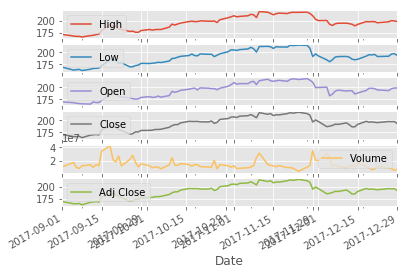

In [43]:
# A quick validation of our downloaded data.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.plot(subplots=True);

# **Train and test dataset split**

In [0]:
# split into input (X) and output (Y) variables

dataset = df.values

# take only the stock price at adj Close
stock = dataset[:,5]

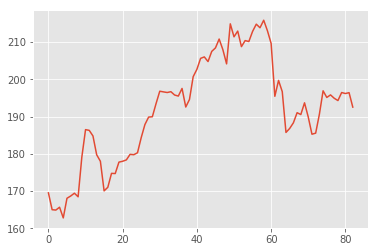

In [47]:
plt.plot(stock);

# Data preparation

The CNN model will learn a function that maps a *sequence of past observations as input to an output observation*. As such, the sequence of observations must be transformed into multiple examples from which the model can learn.

E.g.: A continuous timeseries data D =  [10, 20, 30, 40, 50, 60, 70, 80, 90] is transformed into sequence as:

Input Sequence (X),	Output (Y)

[10, 20, 30] -> 40

[20, 30, 40] -> 50

[30, 40, 50] -> 60

...



In [0]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
# define input sequence
raw_seq = stock

# choose a widow size, i.e. the number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

  


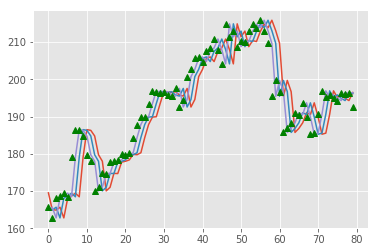

In [56]:
plt.plot(X);
# green triangles are the current stock based on the previous n_steps
plt.plot(y, 'g^')
plt.show()

In [71]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# get dataset dimension
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((72, 3, 1), (72,), (8, 3, 1), (8,))

# The CNN Model

In [0]:
# A simple CNN model for regression
def baseline_cnn_model():
  # create model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(n_steps, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))
  # Compile model
  model.compile(optimizer='adam', loss='mse') 
  #The model is fit using the efficient Adam version of 
  #stochastic gradient descent (SGD) and optimized using the mean squared error,
  #or ‘mse‘, loss function.
  
  return model

# **Training**

In [0]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
#'''NOTE: We almost always have multiple samples, therefore, 
#the model will expect the input component of training data 
#to have the dimensions or shape:'''

In [75]:
# fit model
model = baseline_cnn_model()
model.summary()
model.fit(x_train, y_train, epochs=1000, verbose=0, batch_size=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
_________________________________________________________________


# Testing

In [76]:
score = model.evaluate(x_test, y_test, batch_size=10)
score

8/8 [==============================] - 0s 9ms/step


22.59844398498535

In [77]:
# make a prediction
predicted = model.predict(x_test)
# show the inputs and predicted outputs
for i in range(len(x_test)):
	print("X=%s, Predicted=%s" % (x_test[i, 0:13:2], predicted[i]))

X=[[199.71751404]
 [185.73695374]], Predicted=[192.73982]
X=[[197.56027222]
 [194.58712769]], Predicted=[193.425]
X=[[209.6680603 ]
 [199.71751404]], Predicted=[196.33046]
X=[[174.73960876]
 [177.76249695]], Predicted=[178.28856]
X=[[205.6444397 ]
 [204.77935791]], Predicted=[205.54175]
X=[[184.79264832]
 [177.99118042]], Predicted=[178.85948]
X=[[189.86387634]
 [193.49330139]], Predicted=[193.72256]
X=[[170.03627014]
 [174.73960876]], Predicted=[175.62137]


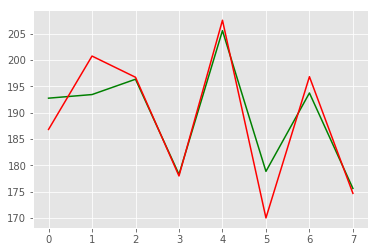

In [78]:
#predicted, y_test

import matplotlib.pyplot as plt

plt.plot(predicted, color='green')
plt.plot(y_test, color='red')
plt.show()